<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Uplift_202309預測**

1. 資料時間
  * 訓練資料：202306+202308活動（0823週三匯元日7523）/data202306_1.csv
  * 測試資料：202309
  * 驗證資料：

2. 資料進度


#Train

##資料探索

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202312_1.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [ ]:
#Complete datasets
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Load your May data
dec_data = pd.read_csv('/content/data202312_1.csv', index_col = 0)
dec_data = dec_data.reset_index(drop = True)
dec_data['換匯發送名單'] = dec_data['換匯發送名單'].astype('str')

##確認模型有學到
#sep_data['跨售行為'] = [-1 if x == 0 else x for x in sep_data['跨售行為']]
#sep_data['跨售行為'] = sep_data['跨售行為'].astype('str')
# Split the data into train and validation sets
np.random.seed(9487)
train_data, val_data = train_test_split(dec_data, test_size=0.2, random_state=42)
# Specify the treatment and outcome columns
unino = dec_data['UNINO']
X_names = dec_data.columns.drop(['換匯發送名單','TOTALNTAMOUNT', '跨售行為', 'UNINO'])
X_names
#201 columns

Index(['年齡', '公司戶記號', '性別', '呆帳記號_含信用卡', '客戶年收入', '網路會員記號', '網路使用記號_行動銀行',
       '小mma記號', '網路服務記號', '網路使用記號',
       ...
       '客戶行業別_醫療保健', '客戶行業別_金融業', '客戶行業別_電子業', '對帳單寄送記號_0', '對帳單寄送記號_1',
       '對帳單寄送記號_2', '信用卡VIP客戶註記_Y', '外幣存款記號_Y', '信用卡轉呆記號_Y', '信用卡自動扣款記號_Y'],
      dtype='object', length=201)

In [ ]:
import pandas as pd

# Assuming 'treatment' and 'amount' are your column names
cross_table_train = pd.crosstab(train_data['換匯發送名單'], train_data['跨售行為'])
cross_table_val = pd.crosstab(val_data['換匯發送名單'], val_data['跨售行為'])

# Display the cross tables
print("Cross Table for Training Data:")
print(cross_table_train)

print("\nCross Table for Validation Data:")
print(cross_table_val)


Cross Table for Training Data:
跨售行為        -1     1
換匯發送名單              
0       808932  3133
1        34399   815

Cross Table for Validation Data:
跨售行為        -1    1
換匯發送名單             
0       202396  784
1         8459  181


## CasualML_uplift

* 記錄模型時間及存下模型(CasualML_uplift_202306_1/2/3/4/5.pkl)
* 分別存下T = 0/T = 1

In [ ]:
!pip install causalml

In [ ]:
!pip install duecredit

In [ ]:
import numpy as np
import pandas as pd
import duecredit

from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.metrics import plot_gain, get_cumgain
from sklearn.model_selection import train_test_split

import importlib
print(importlib.metadata.version('causalml') )

0.15.0


In [ ]:
##用Subsets跑
import pandas as pd
import random
##Split dataset
random.seed(42)
# Load your May data
#Shuffle the dataset
train_data.sample(frac = 1, random_state = 42).reset_index(drop = True)
#num_subset
num_subset = 5
#subset_size
subset_size = len(train_data)//num_subset

subsets = []
for i in range(num_subset):
  start_idx = i* subset_size
  end_idx = (i+1)* subset_size
  subset = train_data.iloc[start_idx: end_idx]
  subsets.append(subset)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 861320 entries, 181005 to 121958
Columns: 205 entries, UNINO to 信用卡自動扣款記號_Y
dtypes: float64(111), int64(92), object(2)
memory usage: 1.3+ GB


In [ ]:
#節省RAM容量 先將june_data drop掉
import gc
del dec_data
gc.collect()

90

In [ ]:
#16min 5s
%%time
import pickle

for i in range(0,5):
  df = subsets[i]
  #df.drop(columns = 'UNINO', inplace = True)
  uplift_model = UpliftRandomForestClassifier(control_name='0')

  uplift_model.fit(df[X_names].values,
                 treatment=df['換匯發送名單'].values,
                 y=df['跨售行為'].values)
  print('Finish running uplift_202312_'+ str(i+1))
  #Save model
  # Open a file and use dump()
  with open('/content/drive/MyDrive/Model/CasualML_uplift_202312_'+ str(i+1) + '.pkl', 'wb') as file:
      # A new file will be created
      pickle.dump(uplift_model, file)

Finish running uplift_202312_1
Finish running uplift_202312_2
Finish running uplift_202312_3
Finish running uplift_202312_4
Finish running uplift_202312_5
CPU times: user 1min 3s, sys: 7.89 s, total: 1min 11s
Wall time: 49.7 s


In [ ]:
%%time
df_res = uplift_model.predict(train_data[X_names].values, full_output=True)
print(df_res.shape)
df_res

(861320, 5)
CPU times: user 1min 1s, sys: 3.27 s, total: 1min 5s
Wall time: 1min 3s


,0,1,recommended_treatment,delta_1,max_delta
0,0.001188,0.021232,1,0.020044,0.020044
1,0.001834,0.010765,1,0.008930,0.008930
2,0.001470,0.010109,1,0.008639,0.008639
3,0.001573,0.011427,1,0.009855,0.009855
4,0.001707,0.011262,1,0.009555,0.009555
...,...,...,...,...,...
861315,0.001705,0.009470,1,0.007765,0.007765
861316,0.001417,0.012325,1,0.010908,0.010908
861317,0.001593,0.009877,1,0.008284,0.008284
861318,0.003222,0.008381,1,0.005159,0.005159


In [ ]:
#RAM限制無法使用平行方式運算，若環境更好可以考慮加速
%%time
import pickle
import pandas as pd

def load_and_predict(i, df):
    model_path = f"/content/drive/MyDrive/Model/CasualML_uplift_202312_{i}.pkl"
    model = pickle.load(open(model_path, "rb"))
    df_res = model.predict(train_data[X_names].values, full_output=True)
    df[f'Uplift_{i}|T=0'] = df_res.iloc[:,0]
    df[f'Uplift_{i}|T=1'] = df_res.iloc[:,1]
    print(f'Finish running uplift_202312_{i}')
    return df

# 循环运行五个模型
result = pd.DataFrame()
for i in range(1, 6):
    result = load_and_predict(i, result)

# 计算均值
T_cols = [f'Uplift_{i}|T=0' for i in range(1, 6)]
T1_cols = [f'Uplift_{i}|T=1' for i in range(1, 6)]

res = train_data[['UNINO','換匯基因標籤','換匯發送名單','TOTALNTAMOUNT','跨售行為']]
res['Uplift_mean|T=0'] = result[T_cols].mean(axis=1)
res['Uplift_mean|T=1'] = result[T1_cols].mean(axis=1)
res['Uplift_mean'] = res['Uplift_mean|T=1'] - res['Uplift_mean|T=0']

# 结果
res

Finish running uplift_202312_1
Finish running uplift_202312_2
Finish running uplift_202312_3
Finish running uplift_202312_4
Finish running uplift_202312_5
CPU times: user 5min 23s, sys: 19.8 s, total: 5min 43s
Wall time: 5min 34s



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean
181005,A9229924220,71.6215,0,0,0,0.000637,0.017402,0.016765
609938,H1779663160,54.1144,0,0,0,0.002162,0.009622,0.007461
758327,L2757832850,79.7704,0,0,0,0.001327,0.011611,0.010284
34912,A1721922150,71.9411,0,0,0,0.000675,0.019483,0.018807
733481,L1738564250,66.9864,0,0,0,0.001328,0.023032,0.021704
...,...,...,...,...,...,...,...,...
110268,A2704800300,88.0086,0,0,0,0.000696,0.019175,0.018479
259178,D2422776610,69.6171,0,0,0,0.001190,0.013400,0.012211
131932,A2731474670,89.0284,0,0,0,0.001411,0.015727,0.014316
671155,J1772697140,89.8774,0,0,0,0.000579,0.026058,0.025480


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202312_results.csv')
#847279 rows × 8 columns

In [ ]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv', index_col = 0)
res

,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1",Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te_2
0,95.6573,0.0,0.0,0.0,0.003857,171877.611205,-15491.582082,156386.029123,0.004392,0.030030,0.025638,0.008651
1,51.2266,0.0,0.0,0.0,0.005216,60231.893431,-16702.654345,43529.239086,0.003726,0.036421,0.032695,0.012721
2,0.0000,0.0,0.0,0.0,0.088081,185014.157793,-18722.602433,166291.555359,0.004439,0.029362,0.024923,0.002097
3,92.5319,0.0,0.0,0.0,0.009854,105375.134061,-16844.181767,88530.952295,0.004514,0.035176,0.030661,0.012487
4,72.7368,0.0,0.0,0.0,0.004691,134203.240261,-17052.090107,117151.150154,0.004213,0.036763,0.032550,0.010406
...,...,...,...,...,...,...,...,...,...,...,...,...
842527,87.0161,0.0,0.0,0.0,0.003217,92797.450155,-11850.765296,80946.684859,0.005313,0.038764,0.033451,0.005785
842528,34.3924,0.0,0.0,0.0,0.006865,100339.262909,-12616.243079,87723.019830,0.002986,0.045579,0.042592,0.014847
842529,10.1501,0.0,0.0,0.0,0.004856,95744.788643,-16623.983587,79120.805056,0.001671,0.059648,0.057978,0.011749
842530,90.5030,0.0,0.0,0.0,0.003267,112106.141114,-18647.786641,93458.354472,0.003954,0.035925,0.031971,0.008392


##X_Learner

In [ ]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Successfully uninstalled shap-0.44.1


In [ ]:
!pip install --upgrade DecisionTreeClassifier
!pip install scikit-learn==1.2.2

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.1 requires pandas<2.1.4,>=1.5.0, but you have pandas 1.3.5 which is incompatible.
causalml 0.14.1 requires scikit-learn<=1.0.2, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
# Main imports
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

# Helper imports
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
%%time
df = train_data

# Instantiate X learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6)
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6)
X_learner = XLearner(models=models, propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y=df['跨售行為'].values, T = df['換匯發送名單'].values, X=df[X_names].values)

CPU times: user 1h 29min 43s, sys: 6.06 s, total: 1h 29min 49s
Wall time: 1h 30min 16s


In [ ]:
#Save model
import pickle
#Open a file and use dump()
with open('/content/drive/MyDrive/Model/EconML_X_202312.pkl', 'wb') as file:
    pickle.dump(X_learner, file)

In [ ]:
#Load model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/EconML_X_202312.pkl', 'rb') as file:
    # A new file will be created
    X_learner = pickle.load(file)

In [ ]:
# Estimate treatment effects on test data
X = X_learner.effect(train_data[X_names])
X

array([-1.21478194e-04, -1.25024990e-04, -1.21266059e-04, ...,
       -7.48008644e-05, -4.83983043e-05, -1.18517048e-04])

In [ ]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202312_results.csv', index_col = 0)
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean
181005,A9229924220,71.6215,0,0,0,0.000637,0.017402,0.016765
609938,H1779663160,54.1144,0,0,0,0.002162,0.009622,0.007461
758327,L2757832850,79.7704,0,0,0,0.001327,0.011611,0.010284
34912,A1721922150,71.9411,0,0,0,0.000675,0.019483,0.018807
733481,L1738564250,66.9864,0,0,0,0.001328,0.023032,0.021704
...,...,...,...,...,...,...,...,...
110268,A2704800300,88.0086,0,0,0,0.000696,0.019175,0.018479
259178,D2422776610,69.6171,0,0,0,0.001190,0.013400,0.012211
131932,A2731474670,89.0284,0,0,0,0.001411,0.015727,0.014316
671155,J1772697140,89.8774,0,0,0,0.000579,0.026058,0.025480


In [ ]:
res['X_te'] = X
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202312_results.csv')

##One stage X_Learner

In [ ]:
# Main imports
from econml.metalearners import XLearner

# Helper imports
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
%%time
df = train_data

# Instantiate X learner (2 hr 5 min)
models = GradientBoostingRegressor(n_estimators=100, max_depth=6)
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6)
X_learner_value = XLearner(models=models, propensity_model=propensity_model)
# Train X_learner
X_learner_value.fit(Y=df['TOTALNTAMOUNT'].values, T = df['換匯發送名單'].values, X=df[X_names].values)

CPU times: user 1h 34min 20s, sys: 7.95 s, total: 1h 34min 28s
Wall time: 1h 34min 54s


In [ ]:
#Save model

import pickle
#Open a file and use dump()
with open('/content/drive/MyDrive/Model/Value_EconML_X_202312.pkl', 'wb') as file:
    pickle.dump(X_learner_value, file)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Value_EconML_X_202312.pkl', 'rb') as file:
    # A new file will be created
    X_learner_value = pickle.load(file)

In [ ]:
# Estimate treatment effects on test data
X = X_learner_value.effect(train_data[X_names])
X

array([5.47555465, 5.35167528, 5.47668304, ..., 5.84766519, 8.65882621,
       5.57681715])

In [ ]:
res['Value_X'] = X
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202312_results.csv')
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X
181005,A9229924220,71.6215,0,0,0,0.000637,0.017402,0.016765,-0.000121,5.475555
609938,H1779663160,54.1144,0,0,0,0.002162,0.009622,0.007461,-0.000125,5.351675
758327,L2757832850,79.7704,0,0,0,0.001327,0.011611,0.010284,-0.000121,5.476683
34912,A1721922150,71.9411,0,0,0,0.000675,0.019483,0.018807,-0.000122,5.427277
733481,L1738564250,66.9864,0,0,0,0.001328,0.023032,0.021704,-0.000119,5.553540
...,...,...,...,...,...,...,...,...,...,...
110268,A2704800300,88.0086,0,0,0,0.000696,0.019175,0.018479,-0.000291,6.107345
259178,D2422776610,69.6171,0,0,0,0.001190,0.013400,0.012211,0.000971,5.774477
131932,A2731474670,89.0284,0,0,0,0.001411,0.015727,0.014316,-0.000075,5.847665
671155,J1772697140,89.8774,0,0,0,0.000579,0.026058,0.025480,-0.000048,8.658826


## EconML_RF

* 紀錄金額(profit)模型

In [ ]:
#62282
deal_train  = train_data[train_data['跨售行為']==1]
deal_val = val_data[val_data['跨售行為']==1]
#deal_train['換匯發送名單'] = deal_train['換匯發送名單'].astype('float')
deal_train
#3948 rows × 205 columns

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
324843,E2772683940,45,0,2.0,0,1000.0,1,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1000412,T1710869780,23,0,1.0,0,100.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
952900,R2771786010,50,0,2.0,0,1200.0,1,2,0,3,...,0,0,0,0,0,1,0,1,0,0
163292,A2780548060,40,0,2.0,0,500.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
407117,F1759170380,50,0,1.0,0,0.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909210,Q2728193370,54,0,2.0,0,600.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
308623,E2721050080,46,0,2.0,0,0.0,1,1,0,3,...,0,1,0,0,0,1,0,1,0,0
420182,F1777625000,57,0,1.0,0,2336.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,1
910886,Q2737001020,23,0,2.0,0,600.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
!pip install econml

In [ ]:
import numpy as np
import pandas as pd

import os
import urllib.request

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# EconML imports
from econml.grf import RegressionForest, CausalForest
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

import importlib
print(importlib.metadata.version('econml') )

0.15.0


In [ ]:
deal_train['換匯發送名單'] = deal_train['換匯發送名單'].astype('float')
df = deal_train[deal_train['換匯發送名單']==0]
df
#3133 rows × 205 columns


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
324843,E2772683940,45,0,2.0,0,1000.0,1,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1000412,T1710869780,23,0,1.0,0,100.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
407117,F1759170380,50,0,1.0,0,0.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
513625,F2762349740,30,0,2.0,0,240.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
189544,B1752255400,28,0,1.0,0,500.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909210,Q2728193370,54,0,2.0,0,600.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
308623,E2721050080,46,0,2.0,0,0.0,1,1,0,3,...,0,1,0,0,0,1,0,1,0,0
420182,F1777625000,57,0,1.0,0,2336.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,1
910886,Q2737001020,23,0,2.0,0,600.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
%%time
#CPU times: user 56.6 s, sys: 184 ms, total: 56.7 s
#Wall time: 50.5 s
#RegressionForest(n_estimators=400, random_state=1235)
est_2 = RegressionForest(n_estimators=400, min_samples_leaf=5, max_depth=None,
                       min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                       warm_start=False, inference=True, subforest_size=4,
                       honest=True, verbose=0, n_jobs=-1, random_state=1235)

est_2.fit(X = df[X_names].values, y = df['TOTALNTAMOUNT'].values)

CPU times: user 6.31 s, sys: 37.8 ms, total: 6.34 s
Wall time: 5.66 s


RegressionForest(n_estimators=400, random_state=1235)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_RF_202312.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(est_2, file)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_RF_202312.pkl', 'rb') as file:
    # A new file will be created
    est_2 = pickle.load(file)

In [ ]:
t_pred = est_2.predict(train_data[X_names])
t_pred

array([[2489.03770793],
       [2482.6303323 ],
       [2525.00709183],
       ...,
       [2491.61397337],
       [2533.99727234],
       [2601.59950969]])

##EconML_CFDML

In [ ]:
df = deal_train

In [ ]:
%%time
# Train EconML model
#CPU times: user 4min 7s, sys: 770 ms, total: 4min 8s
#Wall time: 3min 21s

# Initialize and fit the CausalForestDML model with discrete treatment
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from econml.dml import CausalForestDML

est = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
                       random_state=123)

# Fit the model to your data
est.tune(Y=df['TOTALNTAMOUNT'].values, T=df['換匯發送名單'].values, X=df[X_names].values)
est.fit(Y=df['TOTALNTAMOUNT'].values, T=df['換匯發送名單'].values, X=df[X_names].values)

CPU times: user 51.4 s, sys: 303 ms, total: 51.7 s
Wall time: 43.4 s


In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_CF_202312.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(est, file)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_CF_202312.pkl', 'rb') as file:
    # A new file will be created
    est = pickle.load(file)

In [ ]:
# Get treatment effect and its confidence interval
te_pred = est.effect(train_data[X_names])
te_pred
#array([34889.1509029 , 33831.79008391, 49974.03768858, ...,
#       28758.54341653, 35872.75946227, 30689.87590191])

array([-4066.64448604, -4266.56895407, -4081.96732883, ...,
       -4005.19497203, -3918.42173729, -2041.38315608])

In [ ]:
#res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv', index_col = 0)
res['E(V)|T = 0, D = 1'] = t_pred
res['te'] = te_pred
res['E(V)|T = 1, D = 1'] = res['E(V)|T = 0, D = 1'] + res['te']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
181005,A9229924220,71.6215,0,0,0,0.000637,0.017402,0.016765,-0.000121,5.475555,2489.037708,-4066.644486,-1577.606778
609938,H1779663160,54.1144,0,0,0,0.002162,0.009622,0.007461,-0.000125,5.351675,2482.630332,-4266.568954,-1783.938622
758327,L2757832850,79.7704,0,0,0,0.001327,0.011611,0.010284,-0.000121,5.476683,2525.007092,-4081.967329,-1556.960237
34912,A1721922150,71.9411,0,0,0,0.000675,0.019483,0.018807,-0.000122,5.427277,2480.104791,-4216.069783,-1735.964992
733481,L1738564250,66.9864,0,0,0,0.001328,0.023032,0.021704,-0.000119,5.553540,2537.200119,-4090.952762,-1553.752643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,A2704800300,88.0086,0,0,0,0.000696,0.019175,0.018479,-0.000291,6.107345,2546.024216,-3973.202341,-1427.178125
259178,D2422776610,69.6171,0,0,0,0.001190,0.013400,0.012211,0.000971,5.774477,2763.745378,-3943.827252,-1180.081875
131932,A2731474670,89.0284,0,0,0,0.001411,0.015727,0.014316,-0.000075,5.847665,2491.613973,-4005.194972,-1513.580999
671155,J1772697140,89.8774,0,0,0,0.000579,0.026058,0.025480,-0.000048,8.658826,2533.997272,-3918.421737,-1384.424465


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202312_results.csv')
#847279 rows × 13 columns

###Plot

In [ ]:
import pandas as pd
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202312_results.csv', index_col = 0)
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
181005,A9229924220,71.6215,0,0,0,0.000637,0.017402,0.016765,-0.000121,5.475555,2489.037708,-4066.644486,-1577.606778
609938,H1779663160,54.1144,0,0,0,0.002162,0.009622,0.007461,-0.000125,5.351675,2482.630332,-4266.568954,-1783.938622
758327,L2757832850,79.7704,0,0,0,0.001327,0.011611,0.010284,-0.000121,5.476683,2525.007092,-4081.967329,-1556.960237
34912,A1721922150,71.9411,0,0,0,0.000675,0.019483,0.018807,-0.000122,5.427277,2480.104791,-4216.069783,-1735.964992
733481,L1738564250,66.9864,0,0,0,0.001328,0.023032,0.021704,-0.000119,5.553540,2537.200119,-4090.952762,-1553.752643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,A2704800300,88.0086,0,0,0,0.000696,0.019175,0.018479,-0.000291,6.107345,2546.024216,-3973.202341,-1427.178125
259178,D2422776610,69.6171,0,0,0,0.001190,0.013400,0.012211,0.000971,5.774477,2763.745378,-3943.827252,-1180.081875
131932,A2731474670,89.0284,0,0,0,0.001411,0.015727,0.014316,-0.000075,5.847665,2491.613973,-4005.194972,-1513.580999
671155,J1772697140,89.8774,0,0,0,0.000579,0.026058,0.025480,-0.000048,8.658826,2533.997272,-3918.421737,-1384.424465


In [ ]:
train = res.iloc[:,:5]
train['X_te'] = res['X_te']
train['E(V)|T = 0, D = 1'] = res['E(V)|T = 0, D = 1']* res['Uplift_mean|T=0']
train['E(V)|T = 1, D = 1'] = res['E(V)|T = 1, D = 1']* res['Uplift_mean|T=1']
train['Gi'] = train['E(V)|T = 1, D = 1']-train['E(V)|T = 0, D = 1']
train

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,"E(V)|T = 0, D = 1","E(V)|T = 1, D = 1",Gi
181005,A9229924220,71.6215,0,0,0,-0.000121,1.586232,-27.453292,-29.039523
609938,H1779663160,54.1144,0,0,0,-0.000125,5.366923,-17.165874,-22.532797
758327,L2757832850,79.7704,0,0,0,-0.000121,3.350984,-18.078040,-21.429024
34912,A1721922150,71.9411,0,0,0,-0.000122,1.674931,-33.820959,-35.495890
733481,L1738564250,66.9864,0,0,0,-0.000119,3.369435,-35.785443,-39.154877
...,...,...,...,...,...,...,...,...,...
110268,A2704800300,88.0086,0,0,0,-0.000291,1.772285,-27.366795,-29.139081
259178,D2422776610,69.6171,0,0,0,0.000971,3.288238,-15.813673,-19.101910
131932,A2731474670,89.0284,0,0,0,-0.000075,3.515846,-23.804124,-27.319970
671155,J1772697140,89.8774,0,0,0,-0.000048,1.466706,-36.075858,-37.542564


In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(res.iloc[:,0], res['X_te'], label="Uplift")
plt.xlabel('Gene PR')
plt.ylabel('XLearner(train)')
plt.subplot(122)
plt.scatter(res.iloc[:,0],train['Gi'])
plt.xlabel('Gene PR')
plt.ylabel('Expected value lift(train)')
plt.legend()

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','跨售行為',	'Uplift_mean']]
auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=42)

Uplift_mean    4130.202419
Random         3974.911905
dtype: float64

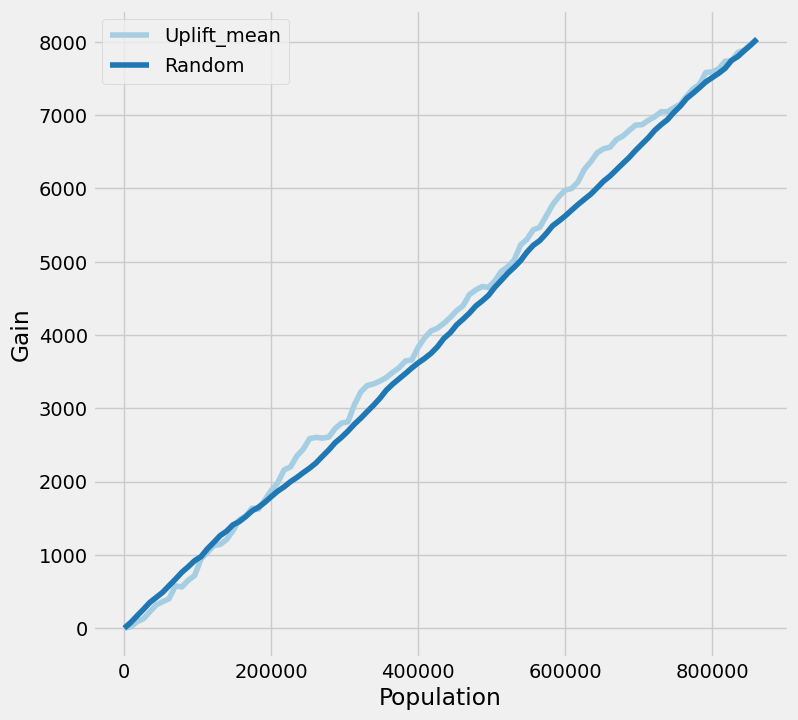

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = res
T =T[['換匯發送名單','跨售行為',	'Uplift_mean']]
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=10)

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','跨售行為',	'X_te']]
auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=42)

X_te      4769.118387
Random    3974.911905
dtype: float64

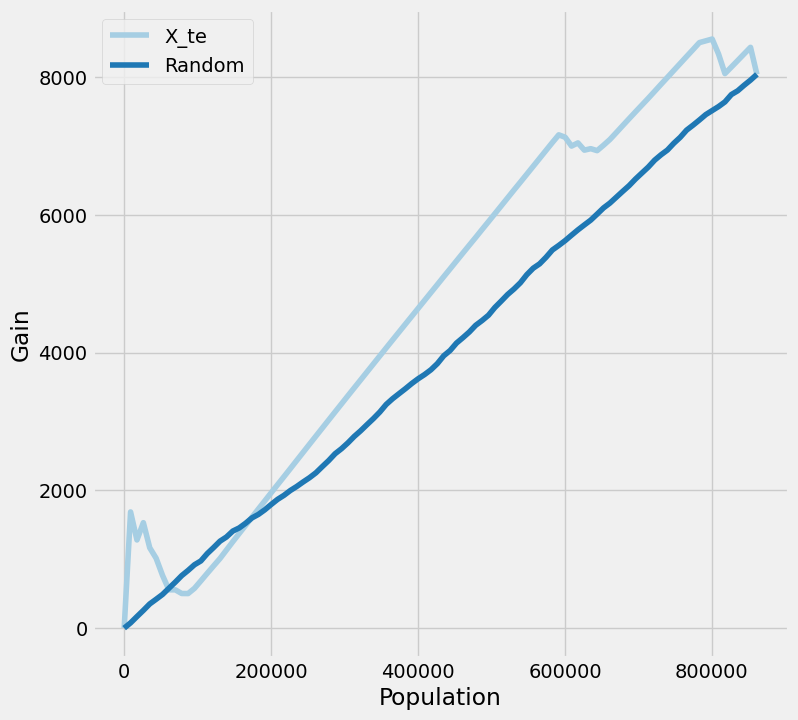

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = res
T =T[['換匯發送名單','跨售行為',	'X_te']]
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=10)

Value_X    3.827399e+08
Random     3.574680e+08
dtype: float64


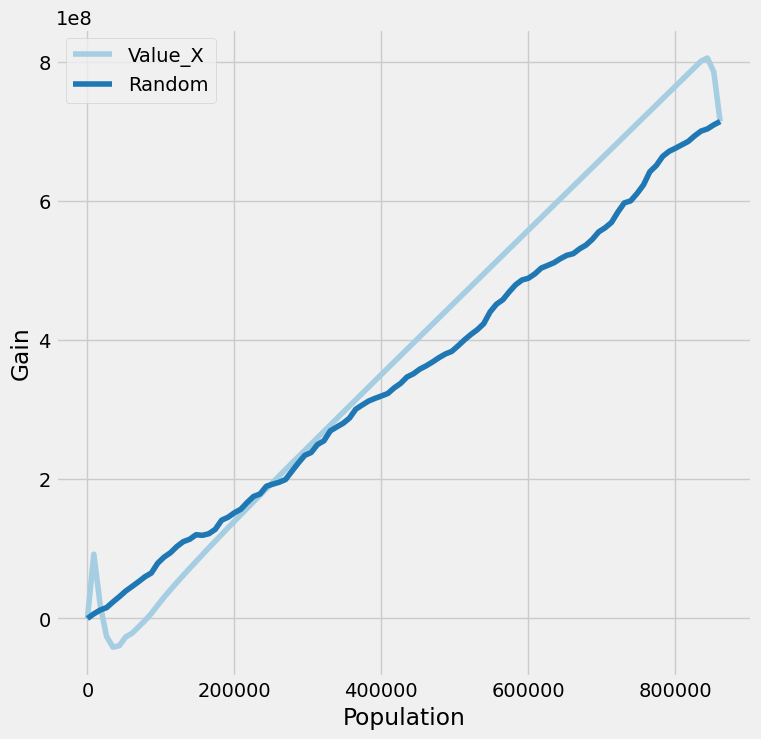

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','TOTALNTAMOUNT',	'Value_X']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=42))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=10)

Gi        4.657347e+08
Random    3.574680e+08
dtype: float64


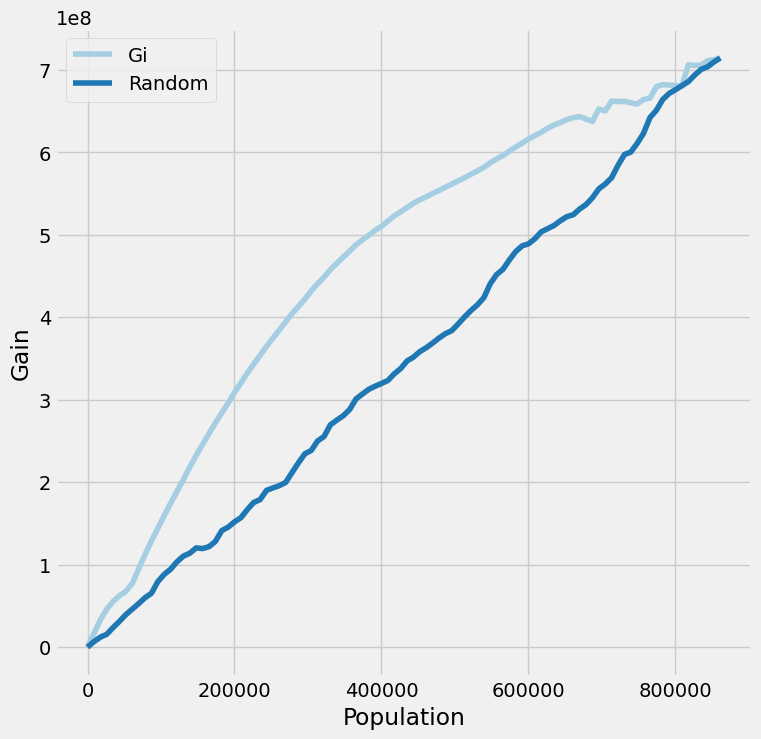

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =train[['換匯發送名單','TOTALNTAMOUNT',	'Gi']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=42))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=10)

#Validation

In [ ]:
#RAM限制無法使用平行方式運算，若環境更好可以考慮加速
%%time
import pickle
import pandas as pd

def load_and_predict(i, df):
    model_path = f"/content/drive/MyDrive/Model/CasualML_uplift_202312_{i}.pkl"
    model = pickle.load(open(model_path, "rb"))
    df_res = model.predict(val_data[X_names].values, full_output=True)
    df[f'Uplift_{i}|T=0'] = df_res.iloc[:, 0]
    df[f'Uplift_{i}|T=1'] = df_res.iloc[:, 1]
    print(f'Finish running uplift_202312_{i}')
    return df

# 循环运行五个模型
result = pd.DataFrame()
for i in range(1, 6):
    result = load_and_predict(i, result)

# 计算均值
T_cols = [f'Uplift_{i}|T=0' for i in range(1, 6)]
T1_cols = [f'Uplift_{i}|T=1' for i in range(1, 6)]

res = val_data[['UNINO','換匯基因標籤','換匯發送名單','TOTALNTAMOUNT','跨售行為']].reset_index(drop = True)
#res['跨售行為'] = val_data['跨售行為'].drop_index()
res['Uplift_mean|T=0'] = result[T_cols].mean(axis=1)
res['Uplift_mean|T=1'] = result[T1_cols].mean(axis=1)
res['Uplift_mean'] = res['Uplift_mean|T=1'] - res['Uplift_mean|T=0']

# 结果
res

Finish running uplift_202312_1
Finish running uplift_202312_2
Finish running uplift_202312_3
Finish running uplift_202312_4
Finish running uplift_202312_5
CPU times: user 1min 27s, sys: 5.22 s, total: 1min 32s
Wall time: 1min 34s


,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean
0,Q1777369550,90.0365,0,0,0,0.002815,0.008499,0.005684
1,M1771565510,49.1271,0,0,0,0.000834,0.028324,0.027490
2,R1771843010,78.2486,0,0,0,0.000697,0.017983,0.017286
3,N2729518770,73.6882,0,0,0,0.001269,0.024213,0.022943
4,F1745627350,57.3852,0,0,0,0.000729,0.020828,0.020099
...,...,...,...,...,...,...,...,...
215326,V2795576720,69.4419,0,0,0,0.001214,0.013537,0.012324
215327,B1790155350,48.7207,0,0,0,0.000992,0.025602,0.024610
215328,A1789611970,56.3578,0,0,0,0.001208,0.013416,0.012207
215329,F2755817950,93.9032,0,0,0,0.006066,0.007629,0.001563


In [ ]:
#Load model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/EconML_X_202312.pkl', 'rb') as file:
    # A new file will be created
    X_learner = pickle.load(file)

In [ ]:
# Estimate treatment effects on test data
X_te = X_learner.effect(val_data[X_names])
X_te

array([-0.00011908, -0.02528377, -0.00012455, ..., -0.00012318,
       -0.0001004 , -0.00012287])

In [ ]:
#Save model
import pickle
#Value_EconML_X_202304.pkl One stage X Learner
with open('/content/drive/MyDrive/Model/Value_EconML_X_202312.pkl', 'rb') as file:
    # A new file will be created
    X_learner_value = pickle.load(file)

In [ ]:
# Estimate treatment effects on test data
X = X_learner_value.effect(val_data[X_names])
X

array([5.49285563, 5.34598121, 5.38036265, ..., 5.42319064, 4.09707884,
       5.40416162])

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_RF_202312.pkl', 'rb') as file:
    # A new file will be created
    est_2 = pickle.load(file)

In [ ]:
t_pred = est_2.predict(val_data[X_names])
t_pred

array([[2705.58059505],
       [2508.69949577],
       [2521.0347441 ],
       ...,
       [2485.82569806],
       [2573.76553575],
       [2552.69624865]])

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_CF_202312.pkl', 'rb') as file:
    est = pickle.load(file)

In [ ]:
# Get treatment effect and its confidence interval
te_pred = est.effect(val_data[X_names])
te_pred

array([-4616.6853022 , -4215.35456147, -8198.35371157, ...,
       -3940.99314312, -4242.13313678, -4035.55483815])

In [ ]:
#res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202312_results.csv', index_col = 0)
res['X_te'] = X_te
res['Value_X'] = X
res['E(V)|T = 0, D = 1'] = t_pred
res['te'] = te_pred
res['E(V)|T = 1, D = 1'] = res['E(V)|T = 0, D = 1'] + res['te']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
0,Q1777369550,90.0365,0,0,0,0.002815,0.008499,0.005684,-0.000119,5.492856,2705.580595,-4616.685302,-1911.104707
1,M1771565510,49.1271,0,0,0,0.000834,0.028324,0.027490,-0.025284,5.345981,2508.699496,-4215.354561,-1706.655066
2,R1771843010,78.2486,0,0,0,0.000697,0.017983,0.017286,-0.000125,5.380363,2521.034744,-8198.353712,-5677.318967
3,N2729518770,73.6882,0,0,0,0.001269,0.024213,0.022943,-0.025057,5.424562,2469.383263,-4185.136285,-1715.753022
4,F1745627350,57.3852,0,0,0,0.000729,0.020828,0.020099,-0.000410,5.358578,2521.637261,-3806.148338,-1284.511077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215326,V2795576720,69.4419,0,0,0,0.001214,0.013537,0.012324,-0.000122,5.426843,2482.148808,-4133.290993,-1651.142185
215327,B1790155350,48.7207,0,0,0,0.000992,0.025602,0.024610,-0.000125,5.350898,2512.756890,-4155.808248,-1643.051358
215328,A1789611970,56.3578,0,0,0,0.001208,0.013416,0.012207,-0.000123,5.423191,2485.825698,-3940.993143,-1455.167445
215329,F2755817950,93.9032,0,0,0,0.006066,0.007629,0.001563,-0.000100,4.097079,2573.765536,-4242.133137,-1668.367601


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202312_results.csv')
#211820 rows × 13 columns

In [2]:
import pandas as pd
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202312_results.csv', index_col = 0)
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
0,Q1777369550,90.0365,0,0,0,0.002815,0.008499,0.005684,-0.000119,5.492856,2705.580595,-4616.685302,-1911.104707
1,M1771565510,49.1271,0,0,0,0.000834,0.028324,0.027490,-0.025284,5.345981,2508.699496,-4215.354561,-1706.655066
2,R1771843010,78.2486,0,0,0,0.000697,0.017983,0.017286,-0.000125,5.380363,2521.034744,-8198.353712,-5677.318967
3,N2729518770,73.6882,0,0,0,0.001269,0.024213,0.022943,-0.025057,5.424562,2469.383263,-4185.136285,-1715.753022
4,F1745627350,57.3852,0,0,0,0.000729,0.020828,0.020099,-0.000410,5.358578,2521.637261,-3806.148338,-1284.511077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215326,V2795576720,69.4419,0,0,0,0.001214,0.013537,0.012324,-0.000122,5.426843,2482.148808,-4133.290993,-1651.142185
215327,B1790155350,48.7207,0,0,0,0.000992,0.025602,0.024610,-0.000125,5.350898,2512.756890,-4155.808248,-1643.051358
215328,A1789611970,56.3578,0,0,0,0.001208,0.013416,0.012207,-0.000123,5.423191,2485.825698,-3940.993143,-1455.167445
215329,F2755817950,93.9032,0,0,0,0.006066,0.007629,0.001563,-0.000100,4.097079,2573.765536,-4242.133137,-1668.367601


In [ ]:
val = res.iloc[:,:5]
val['X_te'] = res['X_te']
val['Uplift_mean'] = res['Uplift_mean']
val['E(V)|T = 0, D = 1'] = res['E(V)|T = 0, D = 1']* res['Uplift_mean|T=0']
val['E(V)|T = 1, D = 1'] = res['E(V)|T = 1, D = 1']* res['Uplift_mean|T=1']
val['Gi'] = val['E(V)|T = 1, D = 1']-val['E(V)|T = 0, D = 1']
val['Value_X'] = res['Value_X']
#res['Value_mean'] = pred['Value_mean']
val

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,Uplift_mean,"E(V)|T = 0, D = 1","E(V)|T = 1, D = 1",Gi,Value_X
0,Q1777369550,90.0365,0,0,0,-0.000119,0.005684,7.615712,-16.241909,-23.857621,5.492856
1,M1771565510,49.1271,0,0,0,-0.025284,0.027490,2.092508,-48.338720,-50.431228,5.345981
2,R1771843010,78.2486,0,0,0,-0.000125,0.017286,1.757295,-102.097796,-103.855091,5.380363
3,N2729518770,73.6882,0,0,0,-0.025057,0.022943,3.134427,-41.543202,-44.677628,5.424562
4,F1745627350,57.3852,0,0,0,-0.000410,0.020099,1.837104,-26.753835,-28.590939,5.358578
...,...,...,...,...,...,...,...,...,...,...,...
215326,V2795576720,69.4419,0,0,0,-0.000122,0.012324,3.012234,-22.351727,-25.363961,5.426843
215327,B1790155350,48.7207,0,0,0,-0.000125,0.024610,2.492692,-42.065784,-44.558475,5.350898
215328,A1789611970,56.3578,0,0,0,-0.000123,0.012207,3.003830,-19.522156,-22.525986,5.423191
215329,F2755817950,93.9032,0,0,0,-0.000100,0.001563,15.612668,-12.728374,-28.341042,4.097079


In [3]:
import pandas as pd
#val.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202312_results_all.csv')
val = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202312_results_all.csv', index_col = 0)
val

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,Uplift_mean,"E(V)|T = 0, D = 1","E(V)|T = 1, D = 1",Gi,Value_X
0,Q1777369550,90.0365,0,0,0,-0.000119,0.005684,7.615712,-16.241909,-23.857621,5.492856
1,M1771565510,49.1271,0,0,0,-0.025284,0.027490,2.092508,-48.338720,-50.431228,5.345981
2,R1771843010,78.2486,0,0,0,-0.000125,0.017286,1.757295,-102.097796,-103.855091,5.380363
3,N2729518770,73.6882,0,0,0,-0.025057,0.022943,3.134427,-41.543202,-44.677628,5.424562
4,F1745627350,57.3852,0,0,0,-0.000410,0.020099,1.837104,-26.753835,-28.590939,5.358578
...,...,...,...,...,...,...,...,...,...,...,...
215326,V2795576720,69.4419,0,0,0,-0.000122,0.012324,3.012234,-22.351727,-25.363961,5.426843
215327,B1790155350,48.7207,0,0,0,-0.000125,0.024610,2.492692,-42.065784,-44.558475,5.350898
215328,A1789611970,56.3578,0,0,0,-0.000123,0.012207,3.003830,-19.522156,-22.525986,5.423191
215329,F2755817950,93.9032,0,0,0,-0.000100,0.001563,15.612668,-12.728374,-28.341042,4.097079


###Plot

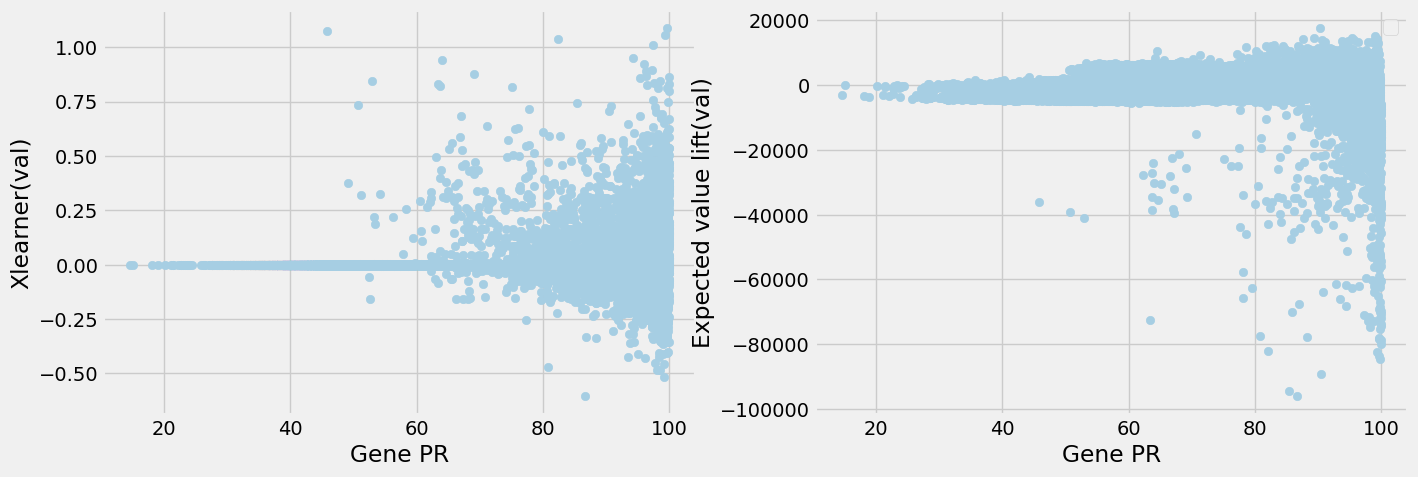

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(val.iloc[:,1], val['X_te'])
plt.xlabel('Gene PR')
plt.ylabel('Xlearner(val)')
plt.subplot(122)
plt.scatter(val.iloc[:,1], val['Gi'])
plt.xlabel('Gene PR')
plt.ylabel('Expected value lift(val)')
plt.legend()

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = val
T =T[['換匯發送名單','跨售行為',	'X_te']]
cumgain = get_cumgain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=42)
cumgain

,X_te,Random
0,0.000000,0.000000
1,0.013753,0.000000
2,0.055012,0.000000
3,0.123776,0.000000
4,0.220047,0.000000
...,...,...
215327,1763.726967,1763.726967
215328,1763.736802,1763.736802
215329,1763.746637,1763.746637
215330,1763.756473,1763.756473


Uplift_mean    602.263587
Random         876.626059
dtype: float64


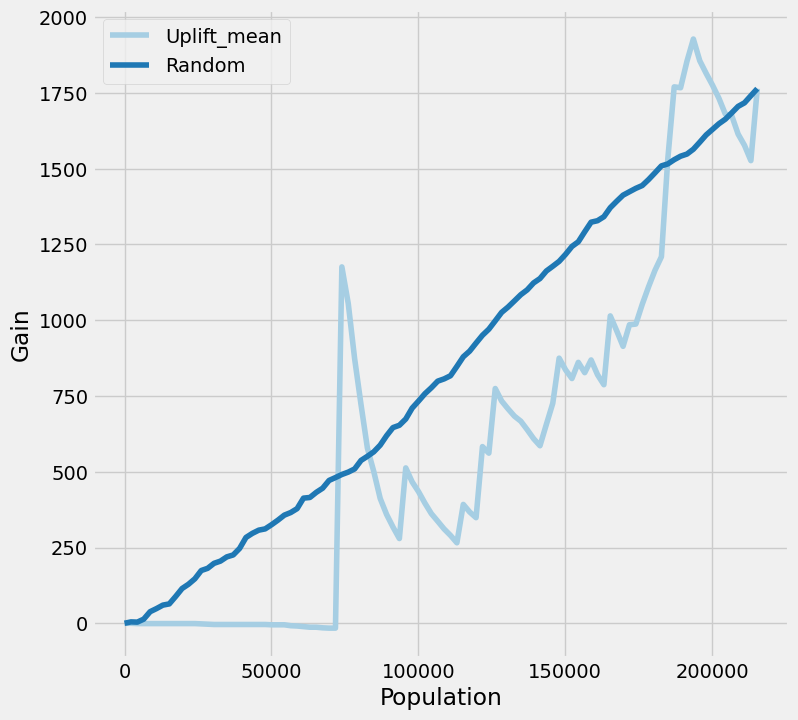

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T = res
T =T[['換匯發送名單','跨售行為',	'Uplift_mean']]
print(auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22))
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22)

X_te      610.464656
Random    876.626059
dtype: float64


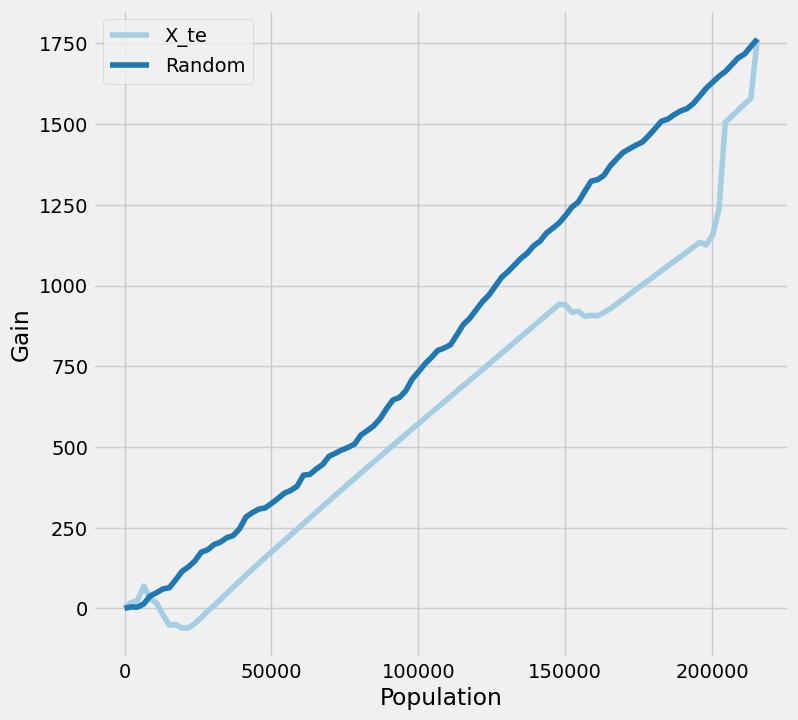

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = res[['換匯發送名單','跨售行為',	'X_te']]
print(auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22))
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22)

Value_X    0.365375
Random     0.462821
dtype: float64


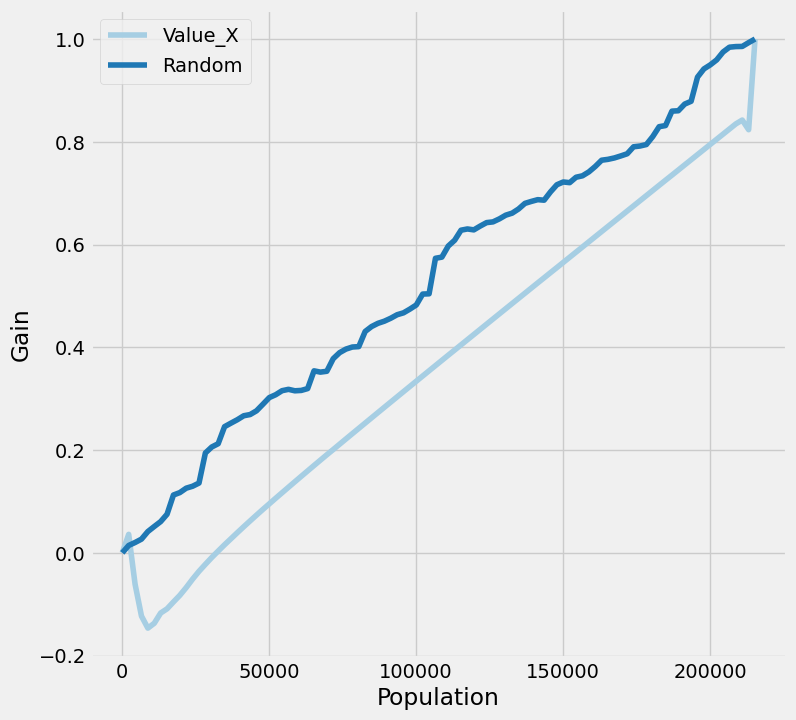

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','TOTALNTAMOUNT',	'Value_X']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=200))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=200)

Gi        0.338039
Random    0.462821
dtype: float64


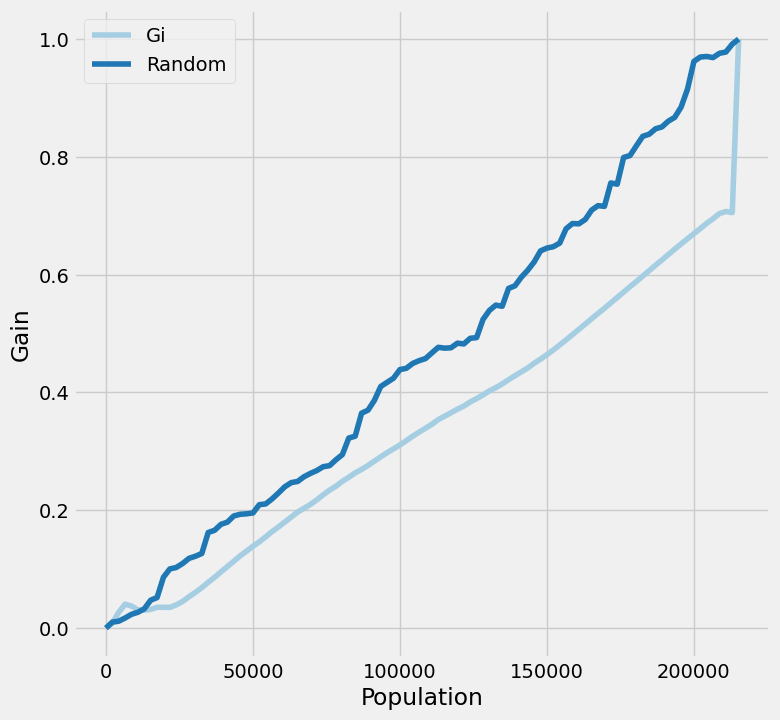

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score, plot_lift
T =val[['換匯發送名單','TOTALNTAMOUNT',	'Gi']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42)
#plot_lift(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', random_seed=42)

### BY percentile

In [4]:
!pip install scikit-uplift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 769.4 kB/s eta 0:00:00


In [5]:
!pip install plotly

In [6]:
import numpy as np
import pandas as pd
#import causalml
import random

%matplotlib inline
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift

In [ ]:
from sklift.metrics import uplift_by_percentile
val['跨售行為'] = [0 if x == -1 else x for x in val['跨售行為']]
uplift_by_perc_df =  uplift_by_percentile(
    val["跨售行為"],
    val["X_te"],
    val["換匯發送名單"],
    strategy="overall",
    total=False,
    std=True,
    bins=10
)

uplift_by_perc_df

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,5631,15903,0.008879,0.011696,-0.002816,0.001250,0.000853,0.001513
10-20,768,20765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20-30,67,21466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30-40,8,21525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40-50,19,21514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50-60,12,21521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60-70,170,21363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70-80,674,20859,0.000000,0.000096,-0.000096,0.000000,0.000068,0.000068
80-90,13,21520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
import pandas as pd
import numpy as np
def response_value_by_percentile(true_value, lift_value, treatment, group, bins=10):

    true_value, lift_value, treatment = np.array(true_value), np.array(lift_value), np.array(treatment)
    order = np.argsort(lift_value, kind='mergesort')[::-1]

    trmnt_flag = 1 if group == 'treatment' else 0


    y_true_bin = np.array_split(true_value[order], bins)
    trmnt_bin = np.array_split(treatment[order], bins)
    group_size = np.array([len(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    response_value = np.array([np.mean(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    variance = np.array([np.var(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    #variance = np.multiply(response_value, np.divide((1 - response_value), group_size))

    return response_value, variance, group_size


def uplift_value_by_percentile(true_value, lift_value, treatment, bins=10, string_percentiles=True):
    true_value, lift_value, treatment = np.array(true_value), np.array(lift_value), np.array(treatment)

    response_value_trmnt, variance_trmnt, n_trmnt = response_value_by_percentile(
        true_value, lift_value, treatment, group='treatment', bins=bins)

    response_value_ctrl, variance_ctrl, n_ctrl = response_value_by_percentile(
        true_value, lift_value, treatment, group='control', bins=bins)

    uplift_scores = response_value_trmnt - response_value_ctrl
    uplift_variance = variance_trmnt + variance_ctrl

    percentiles = [round(p * 100 / bins) for p in range(1, bins + 1)]

    if string_percentiles:
        percentiles = [f"0-{percentiles[0]}"] + \
            [f"{percentiles[i]}-{percentiles[i + 1]}" for i in range(len(percentiles) - 1)]


    df = pd.DataFrame({
        'percentile': percentiles,
        'n_treatment': n_trmnt,
        'n_control': n_ctrl,
        'response_value_treatment': response_value_trmnt,
        'response_value_control': response_value_ctrl,
        'uplift': uplift_scores
    })

    std_treatment = np.sqrt(variance_trmnt)
    std_control = np.sqrt(variance_ctrl)
    std_uplift = np.sqrt(uplift_variance)

    df.loc[:, 'std_treatment'] = std_treatment
    df.loc[:, 'std_control'] = std_control
    df.loc[:, 'std_uplift'] = std_uplift

    df = df \
        .set_index('percentile', drop=True, inplace=False) \
        .astype({'n_treatment': 'int32', 'n_control': 'int32'})

    return df

In [ ]:
uplift_value_by_percentile(
        val["TOTALNTAMOUNT"],
        val['Value_X'],
        val["換匯發送名單"],
        bins=10
    )

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,n_treatment,n_control,response_value_treatment,response_value_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,7312,14222,809.662883,1369.994937,-560.332054,23824.969476,28410.192405,37077.866754
10-20,133,21400,0.000000,9.641215,-9.641215,0.000000,345.966899,345.966899
20-30,1,21532,0.000000,2.329788,-2.329788,0.000000,153.918478,153.918478
30-40,1,21532,0.000000,1.612577,-1.612577,0.000000,151.664437,151.664437
40-50,0,21533,NaN,0.145869,NaN,NaN,21.404524,NaN
50-60,1,21532,0.000000,0.142253,-0.142253,0.000000,20.873474,20.873474
60-70,2,21531,0.000000,0.291951,-0.291951,0.000000,42.838296,42.838296
70-80,0,21533,NaN,0.000000,NaN,NaN,0.000000,NaN
80-90,1,21532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
uplift_by_percentile(
        val["跨售行為"],
        val['X_te'],
        val["換匯發送名單"],
        strategy="by_group",
        total=False,
        std=True,
        bins=10
    )

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,809,20725,0.058096,0.008975,0.049122,0.008224,0.000655,0.008250
10-20,809,20725,0.001236,0.000000,0.001236,0.001235,0.000000,0.001235
20-30,809,20725,0.002472,0.000000,0.002472,0.001746,0.000000,0.001746
30-40,808,20725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40-50,808,20725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50-60,808,20725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60-70,808,20725,0.000000,0.000048,-0.000048,0.000000,0.000048,0.000048
70-80,808,20725,0.000000,0.000048,-0.000048,0.000000,0.000048,0.000048
80-90,808,20724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


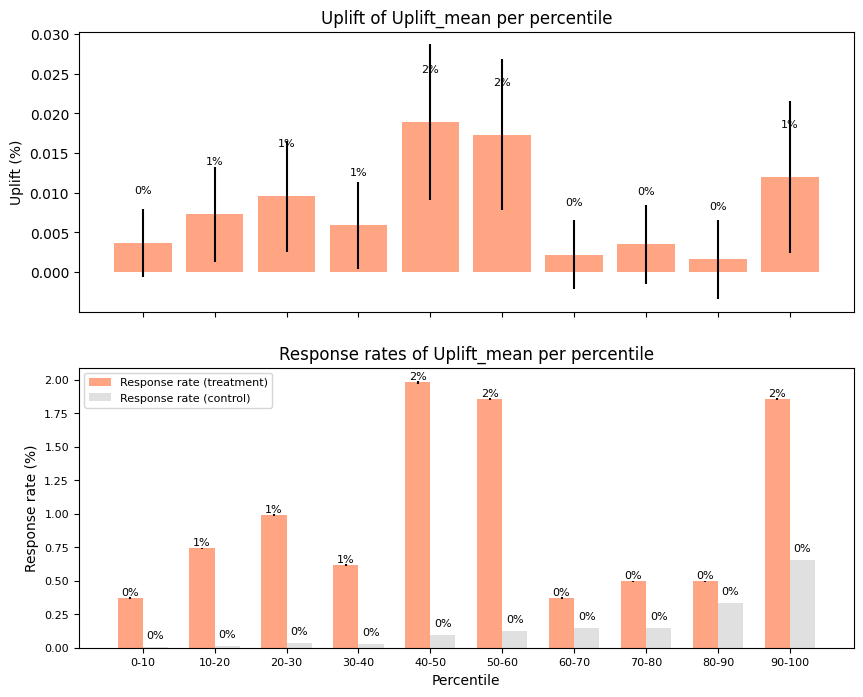

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklift.metrics import uplift_by_percentile

def plot_uplift_by_percentile(df, metric_column, bins=10):
    df['跨售行為'] = [0 if x == -1 else x for x in df['跨售行為']]

    # Fill NaN values in the metric_column with a specific value (e.g., 0)
    df[metric_column].fillna(0, inplace=True)

    uplift_by_perc_df = uplift_by_percentile(
        df["跨售行為"],
        df[metric_column],
        df["換匯發送名單"],
        strategy="by_group",
        total=False,
        std=True,
        bins=bins
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot the first graph (Uplift)
    bars1 = ax1.bar(
        uplift_by_perc_df.index,
        uplift_by_perc_df.uplift,
        yerr=uplift_by_perc_df.std_uplift * 2,
        color='coral',
        alpha=0.7
    )

    ax1.set_title(f'Uplift of {metric_column} per percentile', fontsize=12)
    ax1.set_ylabel('Uplift (%)', fontsize=10)

    # Adding smaller text labels on each bar for Uplift
    for bar, label in zip(bars1, uplift_by_perc_df.uplift):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label * 100)}%', ha='center', va='bottom', fontsize=8)
        else:
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)


    # Plot the second graph (Response Rates for Treatment and Control)
    bar_width = 0.35
    index = np.arange(len(uplift_by_perc_df.index))

    bars2_treatment = ax2.bar(
        index - bar_width/2,
        uplift_by_perc_df.response_rate_treatment * 100,
        bar_width,
        label="Response rate (treatment)",
        color='coral',
        yerr=uplift_by_perc_df.std_treatment * 2,
        alpha=0.7
    )

    bars2_control = ax2.bar(
        index + bar_width/2,
        uplift_by_perc_df.response_rate_control * 100,
        bar_width,
        label="Response rate (control)",
        color='lightgrey',
        yerr=uplift_by_perc_df.std_control * 2,
        alpha=0.7
    )

    ax2.set_title(f'Response rates of {metric_column} per percentile', fontsize=12)
    ax2.set_xlabel('Percentile', fontsize=10)
    ax2.set_ylabel('Response rate (%)', fontsize=10)
    ax2.legend(fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Treatment)
    for bar, label in zip(bars2_treatment, uplift_by_perc_df.response_rate_treatment * 100):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label )}%', ha='center', va='bottom', fontsize=8)
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)
    # Adding smaller text labels on each bar for Response Rates (Control)
    for bar, label in zip(bars2_control, uplift_by_perc_df.response_rate_control ):
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{round(label)}%', ha='center', va='bottom', fontsize=8)

    # Set smaller font size for tick labels
    ax2.tick_params(axis='both', which='major', labelsize=8)

    # Ensure that the y-axis starts from 0
    ax2.set_ylim(bottom=0)

    plt.show()

# Usage example for 'Uplift_mean' column
plot_uplift_by_percentile(val, 'Uplift_mean')

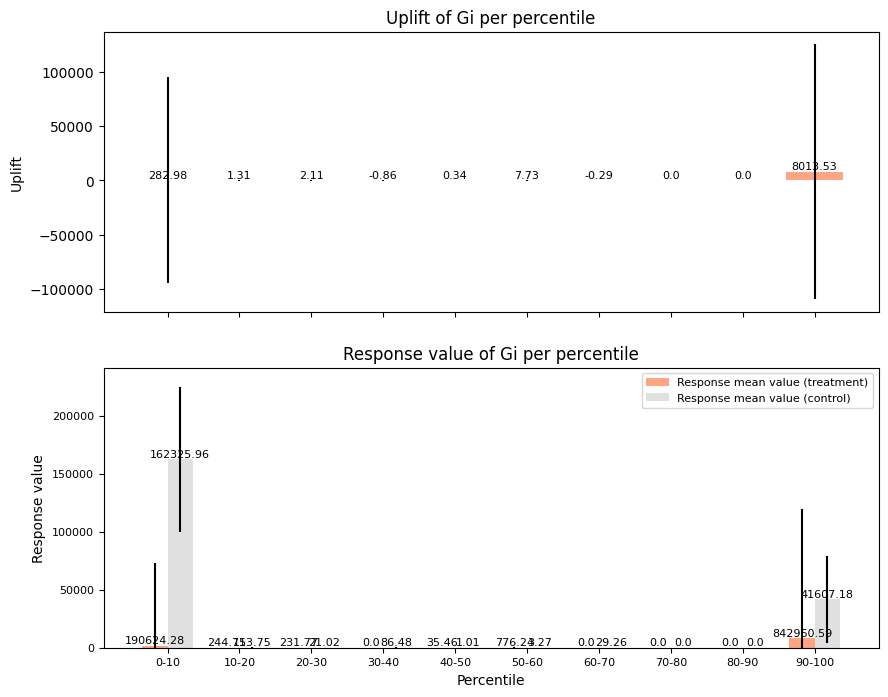

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklift.metrics import uplift_by_percentile

def plot_uplift_value_by_percentile(df, metric_column, bins=10):

    # Fill NaN values in the metric_column with a specific value (e.g., 0)
    df[metric_column].fillna(0, inplace=True)

    uplift_by_perc_df = uplift_value_by_percentile(
        val["TOTALNTAMOUNT"],
        val[metric_column],
        val["換匯發送名單"],
        bins=10
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot the first graph (Uplift)
    bars1 = ax1.bar(
        uplift_by_perc_df.index,
        uplift_by_perc_df.uplift,
        yerr=uplift_by_perc_df.std_uplift * 2,
        color='coral',
        alpha=0.7
    )

    ax1.set_title(f'Uplift of {metric_column} per percentile', fontsize=12)
    ax1.set_ylabel('Uplift', fontsize=10)

    # Adding smaller text labels on each bar for Uplift
    for bar, label in zip(bars1, uplift_by_perc_df.uplift):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label, 2)}', ha='center', va='bottom', fontsize=8)
        else:
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)


    # Plot the second graph (Response Rates for Treatment and Control)
    bar_width = 0.35
    index = np.arange(len(uplift_by_perc_df.index))

    bars2_treatment = ax2.bar(
        index - bar_width/2,
        uplift_by_perc_df.response_value_treatment,
        bar_width,
        label="Response mean value (treatment)",
        color='coral',
        yerr=uplift_by_perc_df.std_treatment * 2,
        alpha=0.7
    )

    bars2_control = ax2.bar(
        index + bar_width/2,
        uplift_by_perc_df.response_value_control * 100,
        bar_width,
        label="Response mean value (control)",
        color='lightgrey',
        yerr=uplift_by_perc_df.std_control * 2,
        alpha=0.7
    )

    ax2.set_title(f'Response value of {metric_column} per percentile', fontsize=12)
    ax2.set_xlabel('Percentile', fontsize=10)
    ax2.set_ylabel('Response value', fontsize=10)
    ax2.legend(fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Treatment)
    for bar, label in zip(bars2_treatment, uplift_by_perc_df.response_value_treatment * 100):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label, 2)}', ha='center', va='bottom', fontsize=8)
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)
    # Adding smaller text labels on each bar for Response Rates (Control)
    for bar, label in zip(bars2_control, uplift_by_perc_df.response_value_control * 100):
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{round(label, 2)}', ha='center', va='bottom', fontsize=8)

    # Set smaller font size for tick labels
    ax2.tick_params(axis='both', which='major', labelsize=8)

    # Ensure that the y-axis starts from 0
    ax2.set_ylim(bottom=0)

    plt.show()

# Usage example for 'Uplift_mean' column
plot_uplift_value_by_percentile(val, 'Gi')

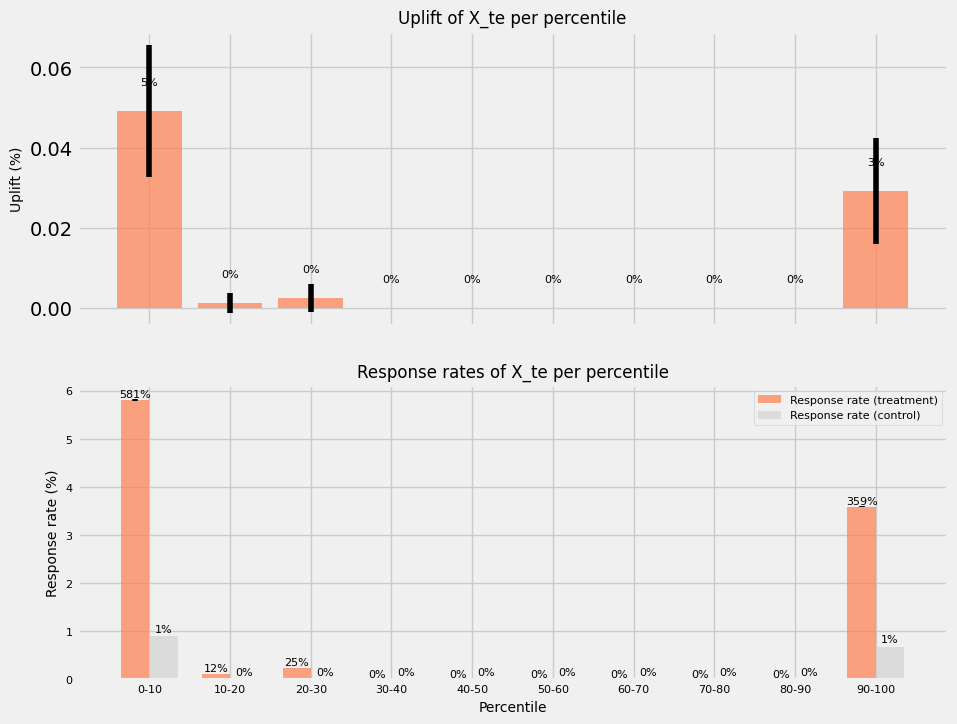

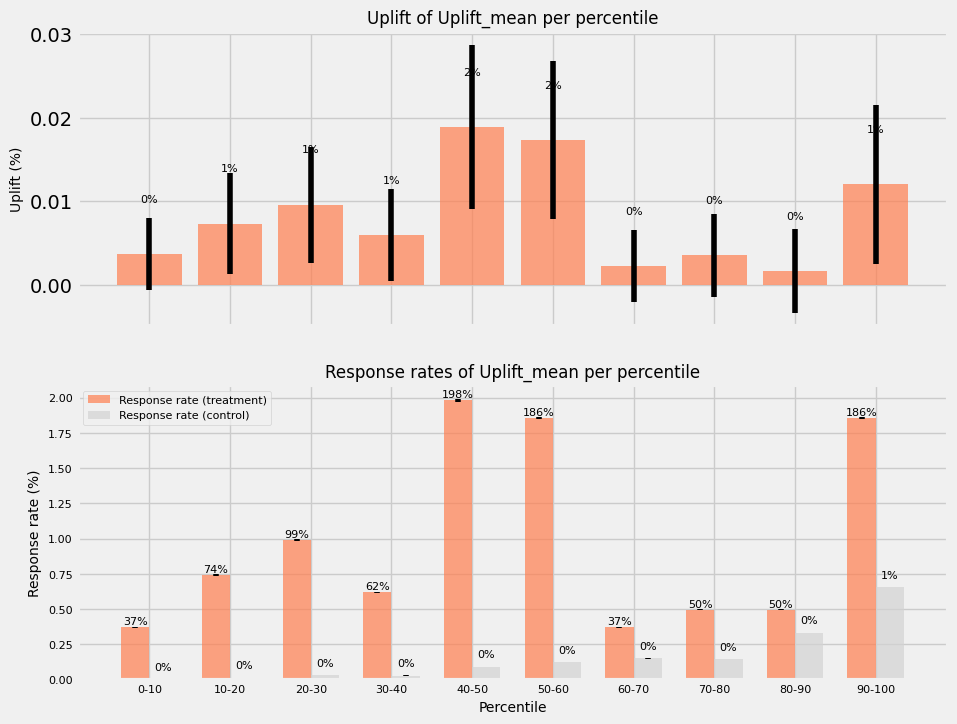

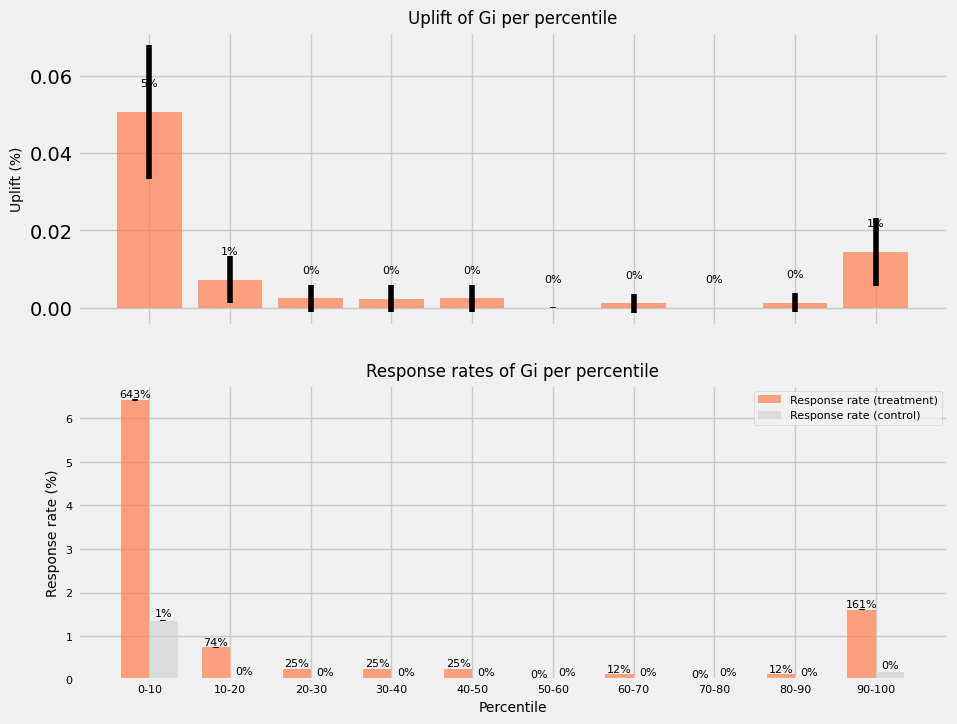

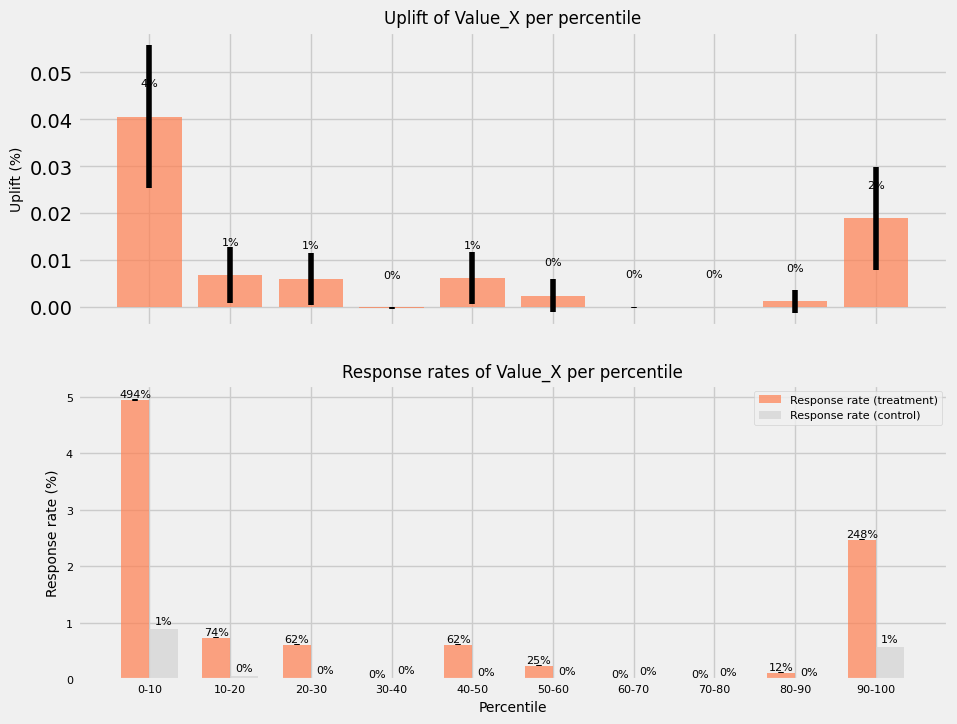

In [ ]:
for cols in ['X_te', 'Uplift_mean', 'Gi', 'Value_X']:
  plot_uplift_by_percentile(val, cols)